<a href="https://colab.research.google.com/github/ishaan-arya/automated-essay-grading/blob/main/Automated_Essay_Grading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pyspellchecker

     |████████████████████████████████| 2.7 MB 4.3 MB/s 


In [3]:
#importing the required libraries
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from nltk.corpus import wordnet
import re, collections
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, r2_score, f1_score, cohen_kappa_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from spellchecker import SpellChecker

**Data Normalization**

In [4]:
from google.colab import files
uploaded = files.upload()

Saving training_set_rel3.csv to training_set_rel3.csv


In [5]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded['training_set_rel3.csv']))

In [6]:
#selecting essay set 1-6 
df2 = df2[df2['essay_set'] < 7]
df2

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10679,16629,6,The one obstacle the builders had when trying ...,2,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10680,16630,6,Some of the problems with the constructing of ...,1,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10681,16631,6,The builders of the Empire State building face...,2,3,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10682,16632,6,The obstacles the builders of the Empire State...,2,1,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df2 = df2.dropna(axis=1)
df2 = df2.drop(['rater1_domain1', 'rater2_domain1'], axis = 1)
df2

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8
...,...,...,...,...
10679,16629,6,The one obstacle the builders had when trying ...,0
10680,16630,6,Some of the problems with the constructing of ...,2
10681,16631,6,The builders of the Empire State building face...,3
10682,16632,6,The obstacles the builders of the Empire State...,2


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


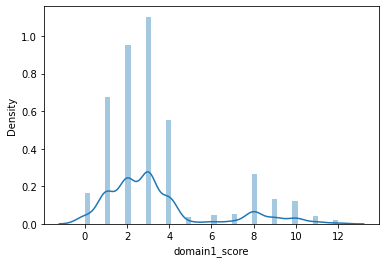

In [8]:
sns.distplot(df2['domain1_score'])

In [9]:
min_range = [2,1,0,0,0,0]
max_range = [12,6,3,3,4,4]

#using min-max normalisation
def normalize(x,mi,ma):
    x = (x-mi)/(ma-mi)
    return round(x*10)

df2['final_score']=df2.apply(lambda x:normalize(x['domain1_score'],min_range[x['essay_set']-1],max_range[x['essay_set']-1]),axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


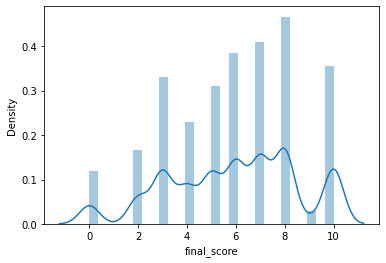

In [10]:
sns.distplot(df2['final_score'])

In [11]:
df2.drop('domain1_score',axis=1,inplace=True)
df2.head()

,essay_id,essay_set,essay,final_score
0,1,1,"Dear local newspaper, I think effects computer...",6
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",7
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",5
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",8
4,5,1,"Dear @LOCATION1, I know having computers has a...",6


In [12]:
df2.describe()

,essay_id,essay_set,final_score
count,10684.000000,10684.000000,10684.000000
mean,8324.558499,3.506739,5.895170
std,5101.949452,1.713837,2.627745
min,1.000000,1.000000,0.000000
25%,3865.750000,2.000000,4.000000
50%,8895.500000,4.000000,6.000000
75%,12760.250000,5.000000,8.000000
max,16633.000000,6.000000,10.000000


**Data Cleaning**

In [13]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def clean_essay(essay):
    x=[]
    for i in essay.split():
        if i.startswith("@"):
            continue
        else:
            x.append(i)
    return ' '.join(x)

df2['essay'] = df2['essay'].apply(lambda x:clean_essay(x))

stop_words = set(stopwords.words('english')) 

def remove_stop_words(essay):
    word_tokens = word_tokenize(essay) 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    return ' '.join(filtered_sentence)

df2['clean_essay'] = df2['essay'].apply(lambda x:remove_stop_words(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Feature Extraction**

In [14]:
def sent2word(x):
    x=re.sub("[^A-Za-z0-9]"," ",x)
    words=nltk.word_tokenize(x)
    return words

def essay2word(essay):
    essay = essay.strip()
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw = tokenizer.tokenize(essay)
    final_words=[]
    for i in raw:
        if(len(i)>0):
            final_words.append(sent2word(i))
    return final_words
        

def noOfWords(essay):
    count=0
    for i in essay2word(essay):
        count=count+len(i)
    return count

def noOfChar(essay):
    count=0
    for i in essay2word(essay):
        for j in i:
            count=count+len(j)
    return count

def avg_word_len(essay):
    return noOfChar(essay)/noOfWords(essay)

def noOfSent(essay):
    return len(essay2word(essay))

def count_pos(essay):
    sentences = essay2word(essay)
    noun_count=0
    adj_count=0
    verb_count=0
    adverb_count=0
    for i in sentences:
        pos_sentence = nltk.pos_tag(i)
        for j in pos_sentence:
            pos_tag = j[1]
            if(pos_tag[0]=='N'):
                noun_count+=1
            elif(pos_tag[0]=='V'):
                verb_count+=1
            elif(pos_tag[0]=='J'):
                adj_count+=1
            elif(pos_tag[0]=='R'):
                adverb_count+=1
    return noun_count,verb_count,adj_count,adverb_count
    
def check_spell_errors(essay):
   essay = essay.lower()
   new_essay = re.sub("[^A-Za-z0-9]"," ",essay)
   new_essay = re.sub("[0-9]","",new_essay)
   count=0
   all_words = new_essay.split()
   spell = SpellChecker()
   misspelled = spell.unknown(all_words)
   return len(misspelled)



**Model Training**

In [15]:
#extracting features in the dataset

nltk.download('averaged_perceptron_tagger')

pro_data = df2.copy()
pro_data['char_count'] = pro_data['essay'].apply(noOfChar)
pro_data['word_count'] = pro_data['essay'].apply(noOfWords)
pro_data['sent_count'] = pro_data['essay'].apply(noOfSent)
pro_data['avg_word_len'] = pro_data['essay'].apply(avg_word_len)
pro_data['spell_err_count'] = pro_data['essay'].apply(check_spell_errors)
pro_data['noun_count'], pro_data['adj_count'], pro_data['verb_count'], pro_data['adv_count'] = zip(*pro_data['essay'].map(count_pos))
pro_data

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,essay_id,essay_set,essay,final_score,clean_essay,char_count,word_count,sent_count,avg_word_len,spell_err_count,noun_count,adj_count,verb_count,adv_count
0,1,1,"Dear local newspaper, I think effects computer...",6,"Dear local newspaper , I think effects compute...",1441,344,16,4.188953,5,76,75,18,24
1,2,1,Dear I believe that using computers will benef...,7,Dear I believe using computers benefit us many...,1765,413,17,4.273608,10,98,84,20,19
2,3,1,"Dear, More and more people use computers, but ...",5,"Dear , More people use computers , everyone ag...",1185,276,14,4.293478,2,76,51,20,16
3,4,1,"Dear Local Newspaper, I have found that many e...",8,"Dear Local Newspaper , I found many experts sa...",2284,490,26,4.661224,19,142,96,39,29
4,5,1,Dear I know having computers has a positive ef...,6,Dear I know computers positive effect people ....,2023,469,30,4.313433,8,110,90,32,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10679,16629,6,The one obstacle the builders had when trying ...,0,The one obstacle builders trying build buildin...,681,152,6,4.480263,5,40,29,7,15
10680,16630,6,Some of the problems with the constructing of ...,5,Some problems constructing docking dirigibles ...,319,66,3,4.833333,0,17,14,7,4
10681,16631,6,The builders of the Empire State building face...,8,The builders Empire State building faced obsta...,489,105,5,4.657143,0,31,18,8,6
10682,16632,6,The obstacles the builders of the Empire State...,5,The obstacles builders Empire State Building C...,305,68,2,4.485294,0,19,13,3,6


In [16]:
#vectorization and train-test split

vectorizer = CountVectorizer(max_features = 5000, ngram_range=(1, 3), stop_words='english')
count_vectors = vectorizer.fit_transform(pro_data['clean_essay'])
feature_names = vectorizer.get_feature_names()
X = count_vectors.toarray()
X_full = np.concatenate((pro_data.iloc[:, 5:].to_numpy(), X), axis = 1)
y_full = pro_data['final_score'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.2, random_state = 42)

In [ ]:
X_train.shape

(8547, 5009)

In [ ]:
X_test.shape

(2137, 5009)

Naive Bayes

In [ ]:
#training the Multinomial Naive Bayes classifier model 

from sklearn.naive_bayes import MultinomialNB
count = 0
total = 0
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
y_pred = MNB.predict(X_test)
for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

55.545156761815626

In [ ]:
#training the Gaussian Naive Bayes classifier model

from sklearn.naive_bayes import GaussianNB
count = 0
total = 0
GNB = GaussianNB()
GNB.fit(X_train, y_train)
y_pred = GNB.predict(X_test)
for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

56.29386991109031

In [ ]:
#training the Bernoulli Naive Bayes classifier model 

from sklearn.naive_bayes import BernoulliNB
count = 0
total = 0
BNB = BernoulliNB()
BNB.fit(X_train, y_train)
y_pred = BNB.predict(X_test)
for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

79.41038839494618

Logistic Regression

In [ ]:
#training the logistic regression model
count = 0
total = 0

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='newton-cg')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score_logistic = metrics.accuracy_score(y_pred, y_test)
for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


81.93729527374825

Linear Regression

In [ ]:
#training the linear regression model 

count = 0
total = 0
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test).round()
for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

52.36312587739822

Random Forest

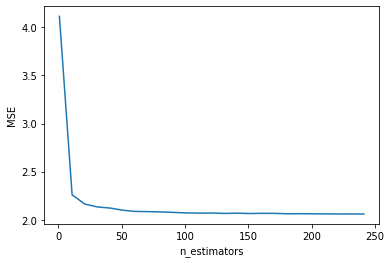

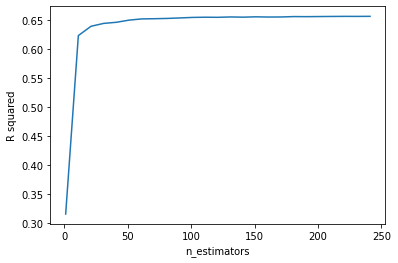

In [ ]:
#finding optimal n_estimators for the random forest regressor model

import matplotlib.pyplot as plt

MSE = []
R2 = []
arr = []
i=1
count = 0
while i<250:
  rf = RandomForestRegressor(n_estimators = i, random_state = 42)
  rf.fit(X_train, y_train)
  y_pred = rf.predict(X_test)
  MSE.append(mean_squared_error(y_test, y_pred))
  R2.append(r2_score(y_test, y_pred))
  arr.append(i)
  print(i,MSE[count])
  print(i,R2[count])
  count = count+1
  i=i+10

plt.plot(arr,MSE)
plt.xlabel('n_estimators') 
plt.ylabel('MSE') 
plt.show()

plt.plot(arr,R2) 
plt.xlabel('n_estimators') 
plt.ylabel('R squared') 
plt.show()

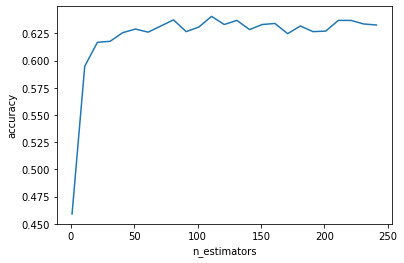

In [ ]:
#finding optimal n-estimators for the random forest classifier model
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

accuracy = []
arr = []
i=1
count = 0
while i<250:
  rf_classifier = RandomForestClassifier(n_estimators = i)
  classifier = rf_classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  accuracy_score_rf = metrics.accuracy_score(classifier.predict(X_test), y_test)
  accuracy.append(metrics.accuracy_score(y_pred, y_test))
  arr.append(i)
  count = count+1
  i=i+10
plt.plot(arr,accuracy) 
plt.xlabel('n_estimators') 
plt.ylabel('accuracy') 
plt.show()


In [ ]:
#training the random forest regressor model
count = 0
total = 0
rf = RandomForestRegressor(n_estimators = 150)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test).round()
for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

95.60131024801123

In [ ]:
#training the random forest classifier model 
from sklearn.ensemble import RandomForestClassifier
total = 0
count = 0
rfc = RandomForestClassifier(n_estimators = 210)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

95.60131024801123

Support Vector Machine

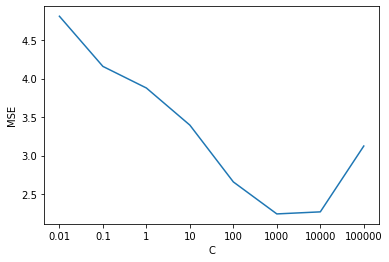

In [17]:
#finding optimal C for the support vector regression model
from sklearn.svm import SVR
c = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
c_val = ['0.01', '0.1', '1', '10','100','1000','10000','100000']
MSE = []
i = 0
while i<8:
  svr = SVR(C=c[i])
  svr.fit(X_train, y_train)
  y_pred = svr.predict(X_test)
  MSE_svc = metrics.mean_squared_error(y_pred, y_test)
  MSE.append(MSE_svc)
  i = i+1
plt.plot(c_val,MSE)
plt.xlabel('C')
plt.ylabel('MSE')
plt.show()

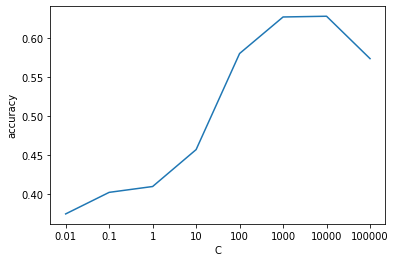

In [ ]:
#finding optimal C for the support vector classifier model
from sklearn.svm import SVC
c = [0.01, 0.1, 1, 10,100, 1000, 10000, 100000]
c_val = ['0.01', '0.1', '1', '10','100','1000','10000','100000']
acc = []
i = 0
while i<8:
  svc = SVC(C=c[i])
  svc.fit(X_train, y_train)
  y_pred = svc.predict(X_test)
  accuracy_score_svc = metrics.accuracy_score(y_pred, y_test)
  acc.append(accuracy_score_svc)
  i = i+1
plt.plot(c_val,acc)
plt.xlabel('C')
plt.ylabel('accuracy')
plt.show()

In [ ]:
#training the support vector regressor model
count = 0
total = 0
svr = SVR(C=1000)
svr.fit(X_train, y_train)
y_pred=svr.predict(X_test).round()
for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

95.60131024801123

In [ ]:
#training the support vector classifier model
from sklearn import svm
count = 0
total = 0
clf = svm.SVC(C=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score_clf = metrics.accuracy_score(y_pred, y_test)
for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

91.4365933551708